In [1]:
#
# In this notebook we download and plot example systems
#
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import wget
import os
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from os.path import basename
from src.regions import *
from src.plotting import * 
from src.pf_stats import *
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [4]:
# Load region to pull examples from
CORE_THRESH = 10


pf_stats = load_global_pf_stats()

area = pf_stats['num_pixels']*25
loc = pf_stats[f'largest_{CORE_THRESH}mmhr_cluster_precip_8conn'] / pf_stats['total_precip']
maxpr = pf_stats['max_precip']

high_area_id = (10000<=area) & (area<=11000)
low_area_id = (5000<=area) & (area<=5100)

high_loc_id = (0.75<=loc) & (loc<=0.8)
low_loc_id = (0.2<=loc) & (loc<=0.3)

extreme_id = maxpr >= 80

regime_dict = {
    'high_area_high_loc': pf_stats[high_area_id & high_loc_id & extreme_id],
    'high_area_low_loc' : pf_stats[high_area_id & low_loc_id & extreme_id],
    'low_area_high_loc' : pf_stats[low_area_id  & high_loc_id & extreme_id],
    'low_area_low_loc'  : pf_stats[low_area_id  & low_loc_id & extreme_id]
}

for regime, data in regime_dict.items():
    print(regime)
    assert(data.shape[0]>0)


# Special requests
problem_id = (150>=area) & (loc<0.15) & (maxpr>100)

high_area_high_loc
high_area_low_loc
low_area_high_loc
low_area_low_loc


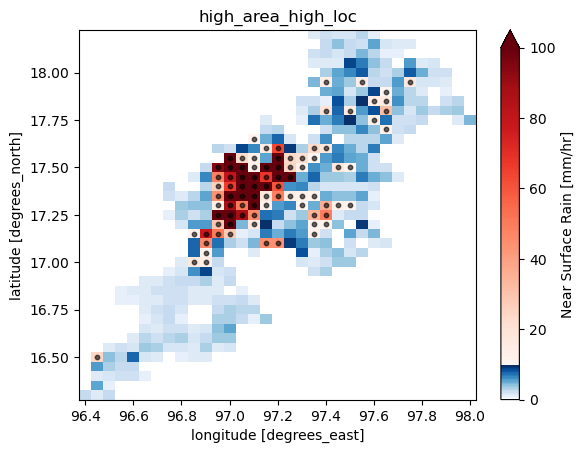

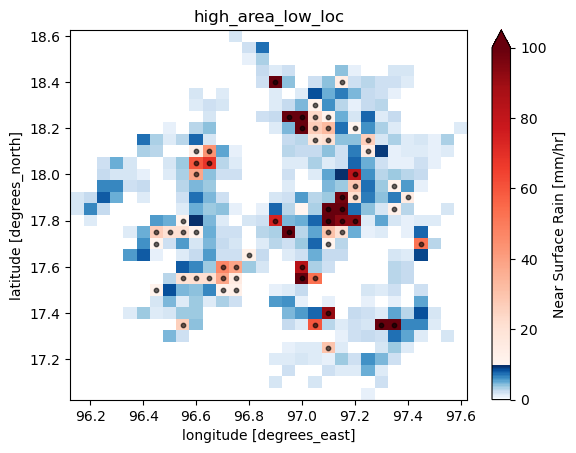

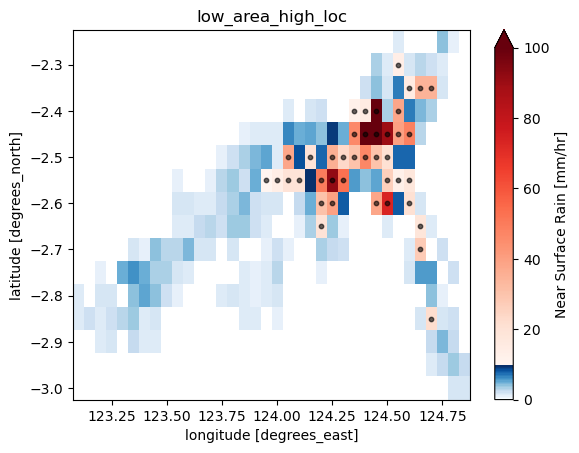

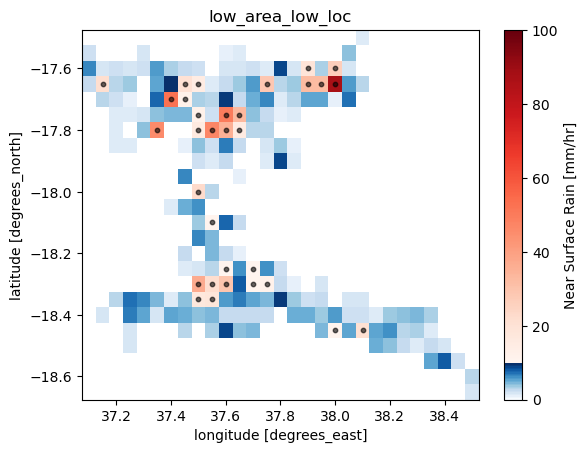

In [11]:
pf_ids = [-1, -2, 0, 0]
for pf_id, (regime, df) in zip(pf_ids, regime_dict.items()):

    #
    # Download file and extract the relevant PF
    file = df['gpm_filename'].iloc[pf_id]
    pf_id = df['feature_id'].iloc[pf_id]
    region_name = file.split('_')[-1].split('.')[0]
    url = f"http://gpm.atmos.washington.edu/{'/'.join(file.split('/')[5:])}"
    out_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}_fullfile.nc'
    if os.path.exists(out_filename):
        os.remove(out_filename) # if exist, remove it directly
    wget.download(url, out_filename)

    swath_data = xr.open_dataset(out_filename).squeeze('time')
    rainy_mask = swath_data['near_surf_rain'] >= 1
    structure = [[1,1,1],[1,1,1],[1,1,1]]
    pf_mask = label(rainy_mask, structure=structure)[0]==pf_id
    pf_mask = rainy_mask.copy(data=pf_mask)
    pf_data = swath_data.where(pf_mask, drop=True)

    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data.to_netcdf(pf_filename)
    
    #
    # Plot the data
    #    
    fig, ax = plt.subplots()
    def create_split_cmap(vmin=0, vmax=100, split=10, cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
        fraction = (split - vmin) / (vmax - vmin)
        n_total = 256
        n_low = int(n_total * fraction)
        n_high = n_total - n_low
        colors_low = cmap_low(np.linspace(0, 1, n_low))
        colors_high = cmap_high(np.linspace(0, 1, n_high))
        merged_colors = np.vstack((colors_low, colors_high))
        split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
        split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
        return split_cmap, split_norm

    cmap_split, norm_split = create_split_cmap(
        vmin=0,
        vmax=100,
        split=10,
        cmap_low=plt.cm.Blues,
        cmap_high=plt.cm.Reds
    )


    pf_data.near_surf_rain.plot(
        ax=ax, 
        cmap=cmap_split,
        norm=norm_split
    )
    ax.set_title(regime)
    
    # Highlight core pixels
    precip = pf_data['near_surf_rain']
    mask = precip >= CORE_THRESH
    lat_vals = precip.coords['lat'].values
    lon_vals = precip.coords['lon'].values
    LON, LAT = np.meshgrid(lon_vals, lat_vals)

    ax.scatter(
        LON[mask], 
        LAT[mask], 
        s=10,          # marker size
        c='black',       # marker color
        alpha=0.6,     # some transparency
        label='>5mm/hr'
    )

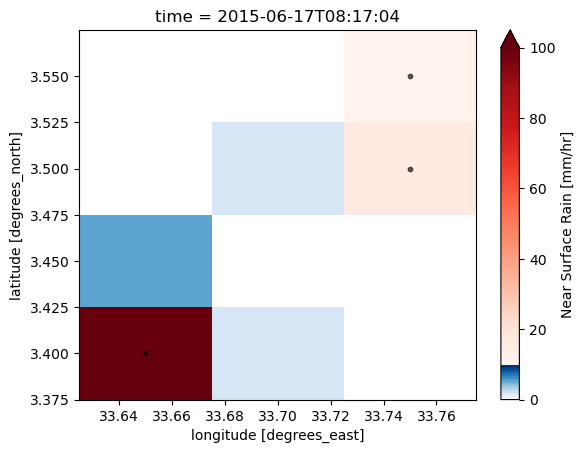

In [15]:
df = pf_stats[problem_id]

pf_id = 0 

file = df['gpm_filename'].iloc[pf_id]
pf_id = df['feature_id'].iloc[pf_id]
region_name = file.split('_')[-1].split('.')[0]
url = f"http://gpm.atmos.washington.edu/{'/'.join(file.split('/')[5:])}"
out_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/problem_fullfile.nc'
if os.path.exists(out_filename):
    os.remove(out_filename) # if exist, remove it directly
wget.download(url, out_filename)

swath_data = xr.open_dataset(out_filename).squeeze('time')
rainy_mask = swath_data['near_surf_rain'] >= 1
structure = [[1,1,1],[1,1,1],[1,1,1]]
pf_mask = label(rainy_mask, structure=structure)[0]==pf_id
pf_mask = rainy_mask.copy(data=pf_mask)
pf_data = swath_data.where(pf_mask, drop=True)

pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/problem.nc'
pf_data.to_netcdf(pf_filename)

#
# Plot the data
#    
fig, ax = plt.subplots()
def create_split_cmap(vmin=0, vmax=100, split=10, cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
    fraction = (split - vmin) / (vmax - vmin)
    n_total = 256
    n_low = int(n_total * fraction)
    n_high = n_total - n_low
    colors_low = cmap_low(np.linspace(0, 1, n_low))
    colors_high = cmap_high(np.linspace(0, 1, n_high))
    merged_colors = np.vstack((colors_low, colors_high))
    split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
    split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return split_cmap, split_norm

cmap_split, norm_split = create_split_cmap(
    vmin=0,
    vmax=100,
    split=10,
    cmap_low=plt.cm.Blues,
    cmap_high=plt.cm.Reds
)


pf_data.near_surf_rain.plot(
    ax=ax, 
    cmap=cmap_split,
    norm=norm_split
)

# Highlight core pixels
precip = pf_data['near_surf_rain']
mask = precip >= CORE_THRESH
lat_vals = precip.coords['lat'].values
lon_vals = precip.coords['lon'].values
LON, LAT = np.meshgrid(lon_vals, lat_vals)

ax.scatter(
    LON[mask], 
    LAT[mask], 
    s=10,          # marker size
    c='black',       # marker color
    alpha=0.6,     # some transparency
    label='>5mm/hr'
)


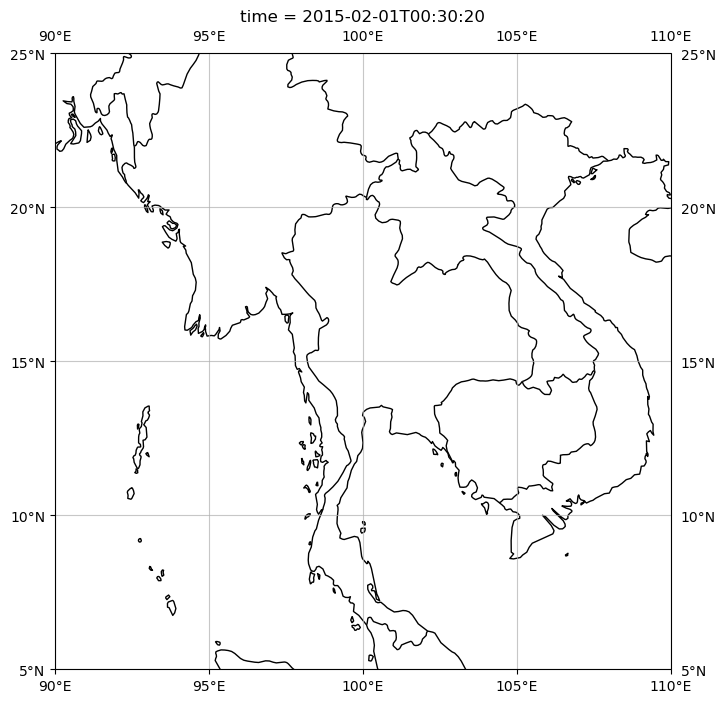

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Create the labeled image from your rainy_mask.
pf_labels = rainy_mask.copy(data=label(rainy_mask, structure=structure)[0])

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8,8))

# Plot the primary data.
pf_labels.plot(
    cmap='tab20', 
    vmin=1,
    add_colorbar=False,
    subplot_kws={'transform': ccrs.PlateCarree()}
)

# Create a mask where swath_data['near_surf_rain'] is NaN.
mask = np.isnan(swath_data['near_surf_rain'].values)
mask_int = mask.astype(int)

# Retrieve coordinate information.
if 'lon' in swath_data.coords and 'lat' in swath_data.coords:
    x = swath_data['lon'].values
    y = swath_data['lat'].values
else:
    ny, nx = mask.shape
    x = np.arange(nx)
    y = np.arange(ny)

# Create a meshgrid if x and y are 1D arrays.
if x.ndim == 1 and y.ndim == 1:
    X, Y = np.meshgrid(x, y)
else:
    X, Y = x, y

# Overlay the swath area with a white fill.
ax.contourf(X, Y, mask_int, levels=[0.5, 1.5],
            colors='white', alpha=1, 
            transform=ccrs.PlateCarree())


# Set lat/lon ticks on top, bottom, left, and right.
x_min, x_max = 90, 110
y_min, y_max = 5, 25
ax.set_extent([x_min, x_max, y_min, y_max])
# Add state boundaries.
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.set_xticks(np.linspace(x_min, x_max, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(y_min, y_max, 5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.tick_params(labeltop=True, labelright=True)
ax.grid(alpha=0.7)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()


TypeError: cannot unpack non-iterable Stamen object

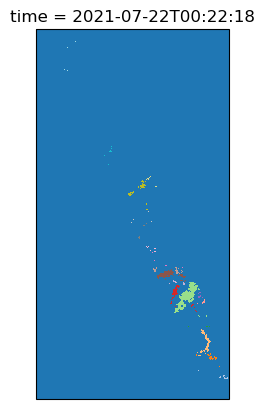

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from scipy.ndimage import zoom

# Create the labeled image from your rainy_mask.
pf_labels = rainy_mask.copy(data=label(rainy_mask, structure=structure)[0])

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the primary data.
pf_labels.plot(cmap='tab20', add_colorbar=False,
               subplot_kws={'transform': ccrs.PlateCarree()})

# Create a boolean mask: True where swath_data['near_surf_rain'] is NaN.
mask = np.isnan(swath_data['near_surf_rain'].values)

# Determine coordinate arrays.
if 'lon' in swath_data.coords and 'lat' in swath_data.coords:
    x = swath_data['lon'].values
    y = swath_data['lat'].values
else:
    ny, nx = mask.shape
    x = np.arange(nx)
    y = np.arange(ny)

# Define the extent (min/max of x and y).
extent = [x.min(), x.max(), y.min(), y.max()]

# ---------------------------------------------------------------------
# Get a real earth image using Cartopy’s tile provider.
tiler = cimgt.Stamen('terrain-background')
zoom_level = 8  # Adjust zoom as needed

# Use keyword arguments for get_image.
earth_img = tiler.get_image()
earth_img_array = np.array(earth_img)  # Convert the PIL image to an array.

# ---------------------------------------------------------------------
# Resize the mask to match the tile image dimensions.
H, W, _ = earth_img_array.shape
mask_float = mask.astype(float)
zoom_factor_y = H / mask.shape[0]
zoom_factor_x = W / mask.shape[1]
mask_resized = zoom(mask_float, (zoom_factor_y, zoom_factor_x), order=0)
mask_resized = (mask_resized > 0.5).astype(np.uint8)

# Create an alpha channel (fully opaque where mask_resized==1, transparent elsewhere).
alpha_channel = mask_resized * 255

# Combine the RGB tile with the alpha channel to form an RGBA image.
rgba_earth = np.dstack((earth_img_array, alpha_channel))

# Overlay the RGBA earth image only where your swath mask is True.
ax.imshow(rgba_earth, extent=extent, transform=ccrs.PlateCarree())

# Add additional features.
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

plt.show()


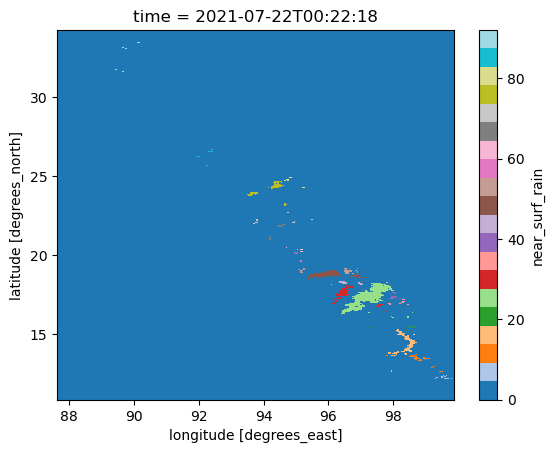

In [21]:

swath = np.isnan(swath_data['near_surf_rain']).plot()



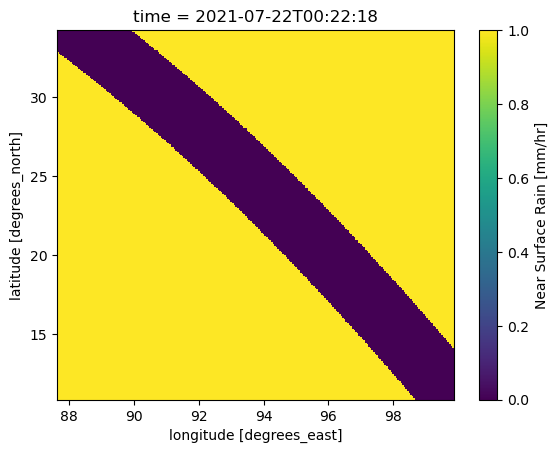